# WISOMIP Boundary Condition File Generation (+/-4 K SST / Sea-Ice)

This notebook follows the AMIP 2 boundary condition protocol described in  
[Taylor et al., 2000, PCMDI Report 60](https://pcmdi.llnl.gov/report/ab60.html) and the official README_nc documentation 
(https://pcmdi.llnl.gov/mips/amip/AMIP2EXPDSN/BCS/amipbc_dwnld_files/360x180/v1.0.0/nc/readme_nc).

The workflow:
- Uses tosbcs and siconcbcs (mid-month boundary condition) fields from the PCMDI-AMIP dataset  
  (`PCMDI-AMIP-1-1-10_gn_187001–202212.nc`).
- Computes the pre-industrial climatology (1901–1950).
- Creates +/- 4 K perturbations for two variants:
  1. `noice` – uniform +/- 4 K perturbation, all ice set to 0 %.
  2. `masked` – +/- 4 K applied only where sea-ice < 15 %.
- Writes outputs in input4MIPs format with consistent metadata.



In [8]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

sst_file = 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-10_gn_187001-202212.nc'
ice_file = 'siconcbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-10_gn_187001-202212.nc'
outdir = 'output_bc/'
os.makedirs(outdir, exist_ok=True)



In [9]:
print("Loading AMIP SST and sea-ice files")

ds_sst = xr.open_dataset(sst_file)
ds_ice = xr.open_dataset(ice_file)

tosbcs = ds_sst["tosbcs"]        # °C
siconc = ds_ice["siconcbcs"]     # %
lon = ds_sst["lon"]
lat = ds_sst["lat"]
time = ds_sst["time"]

years = time.dt.year
print(f"Grid: {len(lon)} x {len(lat)}, Months: {len(time)}")
print(f"Years: {years.min().values}–{years.max().values}")


Loading AMIP SST and sea-ice files
Grid: 360 x 180, Months: 1836
Years: 1870–2022


In [11]:
print("Computing 1901–1950 climatology")

mask = (years >= 1901) & (years <= 1950)
pi_sst = tosbcs.where(mask, drop=True).mean("time", skipna=True)
pi_ice = siconc.where(mask, drop=True).mean("time", skipna=True)

# repeat to 12-month dummy climatology
pi_sst_all = np.repeat(pi_sst.data[..., np.newaxis], 12, axis=2)
pi_ice_all = np.repeat(pi_ice.data[..., np.newaxis], 12, axis=2)
time_pi = np.arange(1, 13)



Computing 1901–1950 climatology


In [13]:
print("Creating +/-4 K PI SST and sea-ice files.")

deltaT = [0, 4, -4]
ice_thr = 15.0  # %

for variant in ["noice", "masked"]:
    for dT in deltaT:
        if variant == "noice":
            sst_new = pi_sst + dT
            ice_new = xr.zeros_like(pi_ice)
        else:
            sst_new = pi_sst.copy()
            mask_ocean = pi_ice < ice_thr
            sst_new = xr.where(mask_ocean, sst_new + dT, sst_new)
            ice_new = pi_ice.copy()

        fname = f"{outdir}tosbcs_piSST_{dT:+02d}k_{variant}_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc"

        ds_out = xr.Dataset(
            data_vars={
                "tosbcs": (("lat", "lon"), sst_new.data.astype("float32")),
                "siconcbcs": (("lat", "lon"), ice_new.data.astype("float32"))
            },
            coords={"lon": lon, "lat": lat, "time": time_pi}
        )
        if os.path.exists(fname):
            os.remove(fname)
        ds_out.to_netcdf(fname)

        ds_out.to_netcdf(fname, mode="w")
        print(os.path.basename(fname))



Creating +/-4 K PI SST and sea-ice files.
tosbcs_piSST_+0k_noice_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc
tosbcs_piSST_+4k_noice_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc
tosbcs_piSST_-4k_noice_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc
tosbcs_piSST_+0k_masked_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc
tosbcs_piSST_+4k_masked_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc
tosbcs_piSST_-4k_masked_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc


In [14]:


f_no0  = f"{outdir}tosbcs_piSST_+0k_noice_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc"
f_no4  = f"{outdir}tosbcs_piSST_+4k_noice_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc"
f_msk0 = f"{outdir}tosbcs_piSST_+0k_masked_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc"
f_msk4 = f"{outdir}tosbcs_piSST_+4k_masked_input4MIPs_CMIP_PCMDI-AMIP-1-1-10_gn_1901-1950climo.nc"

sst_no  = xr.open_dataset(f_no0)["tosbcs"]
sst_no4 = xr.open_dataset(f_no4)["tosbcs"]
sst_msk = xr.open_dataset(f_msk0)["tosbcs"]
sst_msk4= xr.open_dataset(f_msk4)["tosbcs"]
ice_no  = xr.open_dataset(f_no0)["siconcbcs"]
ice_msk = xr.open_dataset(f_msk0)["siconcbcs"]


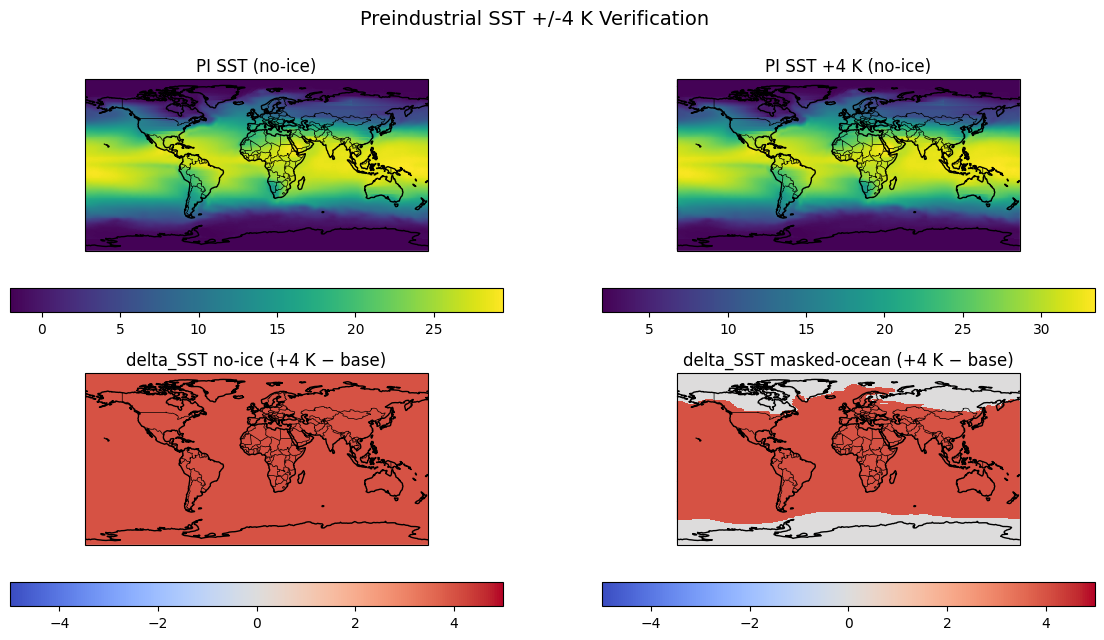

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 7), subplot_kw={"projection": ccrs.PlateCarree()})
axes = axes.ravel()

for ax in axes:
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

p1 = axes[0].pcolormesh(lon, lat, sst_no, transform=ccrs.PlateCarree())
axes[0].set_title("PI SST (no-ice)")
plt.colorbar(p1, ax=axes[0], orientation='horizontal')

p2 = axes[1].pcolormesh(lon, lat, sst_no4, transform=ccrs.PlateCarree())
axes[1].set_title("PI SST +4 K (no-ice)")
plt.colorbar(p2, ax=axes[1], orientation='horizontal')

p3 = axes[2].pcolormesh(lon, lat, sst_no4 - sst_no, cmap="coolwarm", transform=ccrs.PlateCarree(), vmin=-5, vmax=5)
axes[2].set_title("delta_SST no-ice (+4 K − base)")
plt.colorbar(p3, ax=axes[2], orientation='horizontal')

p4 = axes[3].pcolormesh(lon, lat, sst_msk4 - sst_msk, cmap="coolwarm", transform=ccrs.PlateCarree(), vmin=-5, vmax=5)
axes[3].set_title("delta_SST masked-ocean (+4 K − base)")
plt.colorbar(p4, ax=axes[3], orientation='horizontal')

plt.suptitle("Preindustrial SST +/-4 K Verification", fontsize=14)
plt.show()


Plotting ice comparison


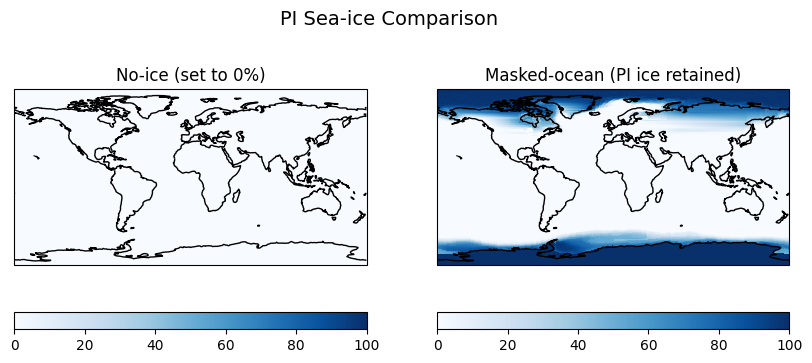

In [7]:
print("Plotting ice comparison")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={"projection": ccrs.PlateCarree()})

for ax in axes:
    ax.set_global()
    ax.coastlines()

p1 = axes[0].pcolormesh(lon, lat, ice_no, vmin=0, vmax=100, cmap="Blues", transform=ccrs.PlateCarree())
axes[0].set_title("No-ice (set to 0%)")
plt.colorbar(p1, ax=axes[0], orientation='horizontal')

p2 = axes[1].pcolormesh(lon, lat, ice_msk, vmin=0, vmax=100, cmap="Blues", transform=ccrs.PlateCarree())
axes[1].set_title("Masked-ocean (PI ice retained)")
plt.colorbar(p2, ax=axes[1], orientation='horizontal')

plt.suptitle("PI Sea-ice Comparison", fontsize=14)
plt.show()

